In [386]:
import numpy as np
from scipy.io import wavfile
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from scipy.signal import correlate, correlation_lags
from scipy.optimize import minimize



In [387]:
my_file = 'B_S2_D1_067-bebop_000_.wav'

In [388]:
sample_rate, data =  wavfile.read(my_file)


In [389]:
measurement_distance = 10.0

# Read the original recording and create an array with the time of each sample
sample_rate, sample=  wavfile.read(my_file)
sample = np.tile(sample, 20)



sample_length = len(sample)
sample_duration = sample_length/sample_rate
print("The original sample is ", sample_duration, " long")
sample_time = np.linspace(0.0, sample_duration, sample_length)

# Configure our soundscape
speed_of_sound = 343
source_start = np.asarray([80.0, 75.0, 0.0])

# TODO: We currently assume that things are moving with constant velocity. But this needs to change to a general
# trajectory defined through coordinates.

velocity = np.broadcast_to([[5.0, 5.0, 0.0]], (sample_length, 3))
position = source_start + velocity * (sample_time - sample_time[0])[:, np.newaxis]
mic_locs = np.asarray([
    [0.0, 0.0, 0.0],
    [0.0, 150.0, 0.0],
    [0.0, 300.0, 0.0],
    [150.0, 0.0, 0.0],
    [150.0, 150.0, 0.0],
    [150.0, 300.0, 0.0],
    [300.0, 0.0, 0.0],
    [300.0, 150.0, 0.0],
    [300.0, 300.0, 0.0]
])
num_mics = mic_locs.shape[0]

# Calculate the arrival times for each microphone -- 
unit_vectors = mic_locs - position[:, np.newaxis, :]
unit_vectors /= np.linalg.norm(unit_vectors, axis=2, keepdims=True)

# This einsum is basically a dot product between the velocity and the unit vectors
# for each point in time
#  we compute the approach speed as follows -- project the velocity at time t of the donre
# with the unit vector between its current position and the locations of all the microphones
approach_speeds = np.einsum('ij,ikj->ik', velocity, unit_vectors)

# Compute all the distances between the microphones and the drone
distances = cdist(position, mic_locs)

damping_ratio = measurement_distance**2/(1.0 + distances)**2

#arrival time  = distance / speed of propagation,  which is approach_speed + speed of sound.
arrival_times = sample_time[:, np.newaxis] + distances / (approach_speeds + speed_of_sound)

arrival_min_overall = arrival_times.min()
arrival_max_overall = arrival_times.max()

# Resample the original recording to get the synthetic recordings
recordings_start = arrival_times.min()
recordings_end = arrival_times.max()
recording_length = recordings_end - recordings_start
recording_samples = int(recording_length * sample_rate)
recordings = np.zeros((num_mics, recording_samples))
recordings_time = np.linspace(recordings_start, recordings_end, recording_samples)

for i in range(num_mics):
    recordings[i, :] = np.interp(recordings_time, arrival_times[:, i], damping_ratio[:,i]*sample, left=0, right=0)

The original sample is  20.48  long


In [390]:
wavfile.write("longer.wav", sample_rate, sample)
wavfile.write("microphone1.wav", sample_rate, recordings[0])
wavfile.write("microphone2.wav", sample_rate, recordings[1])
wavfile.write("microphone3.wav", sample_rate, recordings[2])
wavfile.write("microphone4.wav", sample_rate, recordings[3])

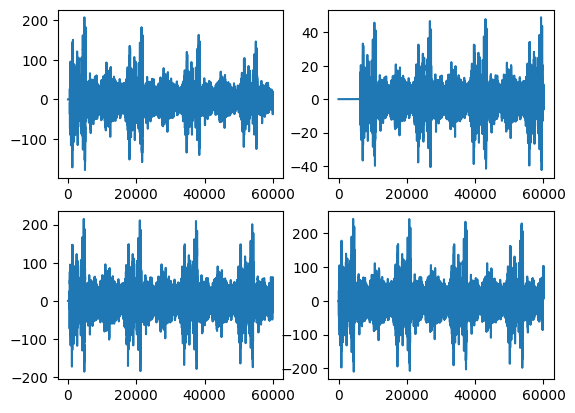

In [391]:
fig, axs  = plt.subplots(2,2)
axs[0,0].plot(recordings[0,:60000] )
axs[1,0].plot(recordings[1,:60000] )
axs[0,1].plot(recordings[2,:60000] )
axs[1,1].plot(recordings[3,:60000] )

In [392]:
def estimate_tdoa(signals, fs, ref=0):
    """
    Estimates the Time Difference of Arrival (TDOA) between multiple signals.
    
    Parameters:
        signals (numpy array): Recorded signals from each microphone.
        fs (int): Sampling frequency.
    
    Returns:
        list: Estimated TDOAs in seconds between the first microphone and others.
    """
    num_mics = signals.shape[0]    
    tdoas = np.zeros(num_mics)

    ref_signal = signals[ref,:]
    for i in range(num_mics):
        correlation = correlate(ref_signal, signals[i,:])
        lags = correlation_lags(len(ref_signal), len(signals[i,:]))
        delay_samples = lags[np.argmax(correlation)]
        tdoas[i] = delay_samples / fs
    
    return tdoas


# This estimates the time delay of arrival at a given time, using a window of the form
# [window/2 - t , window/2 + t]
def estimate_windowed_tdoa(signals, t, window, fs, ref=0):
    """
    Estimates the Time Difference of Arrival (TDOA) between multiple signals.
    
    Parameters:
        signals (numpy array): Recorded signals from each microphone.
        fs (int): Sampling frequency.
    
    Returns:
        list: Estimated TDOAs in seconds between the first microphone and others.
    """
    num_mics = signals.shape[0]    
    tdoas = np.zeros(num_mics)

    left = max(0, t - window//2)
    right = min(signals.shape[1], t + window//2)

    ref_signal = signals[ref,left:right]
    for i in range(num_mics):
        correlation = correlate(ref_signal, signals[i,left:right])
        lags = correlation_lags(len(ref_signal), len(signals[i,left:right]))
        delay_samples = lags[np.argmax(correlation)]
        tdoas[i] = delay_samples / fs
    
    return tdoas

In [393]:
#### Compute windowed tdoa array over a set of time slices

def generate_readings_over_time(samples, window_size, sample_rate, subsample=100):
    arr = []
    for i in range(0, samples.shape[1],subsample):
        arr = arr + [estimate_windowed_tdoa(samples, i, window_size, sample_rate)]

    # generate this to be consistent
    pos_sub = position[::subsample, :]

    # generate time points
    ts = np.arange(pos_sub.shape[0])/(sample_rate/subsample)
    return np.array(arr), pos_sub, ts

tdoa_windows, pos_sub, t_sub = generate_readings_over_time(recordings, 2*sample_rate, sample_rate, 100)


In [394]:
def localization_loss_function(source_position, mic_positions, tdoas, c, prev_guess = None, alpha_reg=1e-2):
    predictions = np.zeros(len(tdoas))
    d_ref = np.linalg.norm(source_position - mic_positions[0,:2])

    for i in range(len(tdoas)):
        d_i = np.linalg.norm(source_position - mic_positions[i,:2])
        predictions[i] = d_ref - d_i

    r = np.sum(np.abs(predictions - c * tdoas))

    if prev_guess is None:
        return r 
    else:
        return r + alpha_reg*np.linalg.norm(source_position-prev_guess)**2

In [395]:

def localize_emitter(mic_positions, tdoas, c=343.0, prev_guess = None):
    """
    Localizes the source using TDOA measurements and microphone positions.
    
    Parameters:
        mic_positions (numpy array): Array of microphone positions [(x1, y1), (x2, y2), ...]
        tdoas (list): Time differences of arrival from the reference microphone to each microphone (s)
        c (float): Speed of sound in the medium (m/s)
    
    Returns:
        numpy array: Estimated source position (x, y)
    """
    if prev_guess is None:
        initial_guess = np.mean(mic_positions[:, :2], axis=0)
    else:
        initial_guess = prev_guess[:2]
        
    print("Initial Guess : ", initial_guess)
    result = minimize(localization_loss_function, initial_guess, args=(mic_positions, tdoas, c, prev_guess, 1.0), bounds=([0.0, 300.0], [0.0, 300.0, ]))
    return result.x

### Localisation based on TDOA

First let's plot a heat map of the most likely positions (smaller = more likely) for a fixed time_index

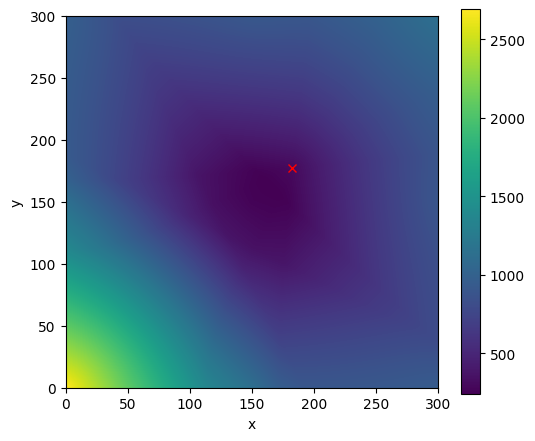

In [396]:
import numpy as np
import matplotlib.pyplot as plt

time_index = -1 # final time

# Define the range for x and y
x = np.linspace(0, 300, 400)
y = np.linspace(0, 300, 400)

# Create a meshgrid
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = localization_loss_function(np.array([X[i,j], Y[i,j]]), mic_locs, tdoa_windows[time_index,:], speed_of_sound)
        
# Plotting
plt.figure(figsize=(6, 5))
plt.imshow(Z, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis')
plt.colorbar()  # Show the color scale
plt.xlabel('x')
plt.ylabel('y')
plt.plot(pos_sub[time_index,0], pos_sub[time_index, 1], 'x', color='red')
plt.show()


# Automated Localisation

Let's use least squares to find the most likely trajectory,  we introduce regularisation (using the last estimate) to smooth the trajectory

In [397]:

predictions = []

location_guess = localize_emitter(mic_locs,tdoa_windows[0,:]).copy()

# for loop to demo
for i in range(pos_sub.shape[0]):
    location_guess = localize_emitter(mic_locs,tdoa_windows[i,:], prev_guess=location_guess).copy()

    print("At time : ", t_sub[i], " we predict location of drone at ", location_guess, ". Actual position is ", pos_sub[i,:])
    predictions = predictions + [location_guess]

predictions = np.array(predictions)

Initial Guess :  [150. 150.]
Initial Guess :  [83.37537739 78.38481264]
At time :  0.0  we predict location of drone at  [83.3753774  78.38481264] . Actual position is  [80. 75.  0.]
Initial Guess :  [83.3753774  78.38481264]
At time :  0.00625  we predict location of drone at  [83.37537739 78.38481264] . Actual position is  [80.0312501 75.0312501  0.       ]
Initial Guess :  [83.37537739 78.38481264]
At time :  0.0125  we predict location of drone at  [83.37537739 78.38481264] . Actual position is  [80.06250019 75.06250019  0.        ]
Initial Guess :  [83.37537739 78.38481264]
At time :  0.01875  we predict location of drone at  [83.37250949 78.39869662] . Actual position is  [80.09375029 75.09375029  0.        ]
Initial Guess :  [83.37250949 78.39869662]
At time :  0.025  we predict location of drone at  [83.37250949 78.39869662] . Actual position is  [80.12500038 75.12500038  0.        ]
Initial Guess :  [83.37250949 78.39869662]
At time :  0.03125  we predict location of drone at 

As we can see the prediction is pretty awful....

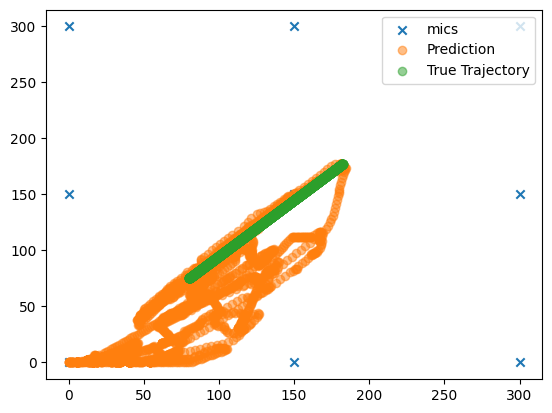

In [398]:
mic_locs_arr = np.array(mic_locs)
plt.scatter(mic_locs_arr[:,0], mic_locs_arr[:,1], marker='x', label='mics')

predictions = np.array(predictions)
plt.scatter(predictions[:,0], predictions[:,1], alpha=0.5, label='Prediction')
plt.scatter(pos_sub[:,0], pos_sub[:,1], alpha=0.5, label='True Trajectory')

plt.legend()

## Particle Filter based localisation

We write a particle filter for tracking the trajectory based on microphone array.    We shall assume a trivial random walk dynamics for the drone

In [399]:

class ParticleFilter:
    def __init__(self, num_particles, initial_distribution, dynamics, observation_density, time_step=1, resample_threshold=10.0, reinit_threshold=0.1):
        self.num_particles = num_particles
        self.particles = initial_distribution(num_particles)
        self.weights = np.ones(num_particles) / num_particles
        self.dynamics = dynamics
        self.observation_density = observation_density
        self.time_step = time_step
        self.time = 0
        self.initial_distribution = initial_distribution
        self.resample_threshold = resample_threshold
        self.reinit_threshold = reinit_threshold

    def predict(self):
        """Evolve particles according to the dynamics model."""
        for i in range(self.num_particles):
            self.particles[i] = self.dynamics(self.particles[i], self.time)

    def update(self):
        """Update weights based on the observation."""
        for i in range(self.num_particles):
            self.weights[i] *= self.observation_density(self.particles[i], self.time)
        self.weights /= np.sum(self.weights)  # Normalize weights

    def effective_sample_size(self):
            """Calculate the effective sample size."""
            return 1.0 / np.sum(self.weights**2)

    def resample_if_needed(self):
        """Resample particles if the effective sample size is below the threshold."""
        if np.isnan(np.sum(self.weights)):
            self.particles = self.initial_distribution(self.num_particles)
            self.weights.fill(1.0 / self.num_particles)
            
            ess = self.effective_sample_size()

            print(f"Reinitialising... Effective sample size: {ess}")


        ess = self.effective_sample_size()

        if ess <= self.resample_threshold:
            print(f"Resampling... Effective sample size: {ess}")
            self.resample()


    def resample(self):
        """Resample particles based on their weights."""
        indices = np.random.choice(self.num_particles, size=self.num_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights.fill(1.0 / self.num_particles)

    def step(self):
        """Perform a full prediction-update-resample cycle."""
        self.resample_if_needed()
        self.predict()
        self.update()
        self.time += self.time_step

    def print_ensemble(self):
        for i in range(self.num_particles):
            print("Particle ", i, " position = ", self.particles[i], " weights ", self.weights[i])

        plt.scatter(self.particles[:,0], self.particles[:,1], c=self.weights)

    def get_mode(self):
        mode_idx = np.argmax(self.weights)
        return self.particles[mode_idx].copy()
    
    def get_mean(self):
        return np.sum(self.weights[:,np.newaxis]*self.particles,axis=0)


In [400]:
# Random walker example
def initial_distribution(num_particles):
    return np.array([np.random.uniform(0, 300, size=num_particles), np.random.uniform(0, 300, size=num_particles)]).T

def dynamics(x, time):
    return x + np.random.normal(0, 1.0, size=2)  # Simple random walk

def observation_density(particle, time):
    return np.exp(-localization_loss_function(np.array([particle[0], particle[1]]), mic_locs, tdoa_windows[time,:], speed_of_sound))

num_particles = 1000
pf = ParticleFilter(num_particles, initial_distribution, dynamics, observation_density)


In [401]:

predictions = []

# Simulate some observations
for i in range(pos_sub.shape[0]):
    pf.step()
    location_guess = pf.get_mean() #pf.get_mode()
    predictions = predictions + [location_guess]

    # print("At time : ", t_sub[i], " we predict location of drone at ", location_guess, ". Actual position is ", pos_sub[i,:])


Resampling... Effective sample size: 1.0000000000000016
Resampling... Effective sample size: 5.529509422978441
Resampling... Effective sample size: 1.9352760921509975
Resampling... Effective sample size: 4.000516305784148
Resampling... Effective sample size: 6.023918693375498
Resampling... Effective sample size: 7.472298836947768
Resampling... Effective sample size: 5.282309966382275
Resampling... Effective sample size: 6.90157580892323
Resampling... Effective sample size: 4.745309010381831
Resampling... Effective sample size: 7.320411581182148
Resampling... Effective sample size: 7.625427837178608
Resampling... Effective sample size: 3.3489494852276933
Resampling... Effective sample size: 8.780800742304576
Resampling... Effective sample size: 5.698905451190282
Resampling... Effective sample size: 9.560115777865914
Resampling... Effective sample size: 7.287584332840504
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998


/var/folders/k2/lfx3bqv519761kv3fb5xmypm0000gr/T/ipykernel_67648/3758030509.py:23: RuntimeWarning: invalid value encountered in divide
  self.weights /= np.sum(self.weights)  # Normalize weights


Resampling... Effective sample size: 1.9971670857286137
Resampling... Effective sample size: 8.73640441012885
Resampling... Effective sample size: 7.788951279460673
Resampling... Effective sample size: 5.586976118024291
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Resampling...

From the plot below, we have a reasonable tracking of the trajectory -- i'm only plotting the posterior mean, the posterior distribution would reveal much more useful information.

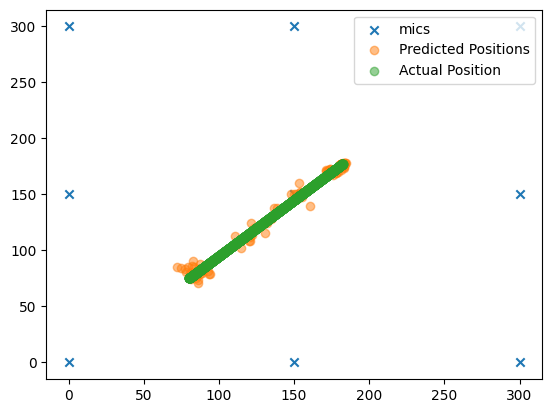

In [402]:
mic_locs_arr = np.array(mic_locs)
plt.scatter(mic_locs_arr[:,0], mic_locs_arr[:,1], marker='x', label='mics')


predictions = np.array(predictions)
plt.scatter(predictions[:,0], predictions[:,1], alpha=0.5, label="Predicted Positions")
plt.scatter(pos_sub[:,0], pos_sub[:,1], alpha=0.5, label="Actual Position")
plt.legend()

Let us now extend this to a more advanced model, where we track both trajectory and velocity over time

In [403]:
# linear motion example
def initial_distribution(num_particles):
    positions =  np.array([np.random.uniform(0, 300, size=num_particles), np.random.uniform(0, 300, size=num_particles)]).T
    velocities = np.random.normal(0, 0.1, size=(num_particles, 2))
    return np.column_stack((positions, velocities))


def dynamics(state, time):
    # Simple model where position updates based on velocity
    x = state[:2]
    v = state[2:]
    x_new = x + v * 1.0  # Update position based on velocity
    v_new = v + np.random.normal(0, 0.02, size=2)  # Slight random change in velocity
    return np.concatenate([x_new, v_new])

def observation_density(particle, time):
    position = particle[:2]
    return np.exp(-localization_loss_function(np.array([position[0], position[1]]), mic_locs, tdoa_windows[time,:], speed_of_sound))

num_particles = 1000
pf = ParticleFilter(num_particles, initial_distribution, dynamics, observation_density)


In [404]:

predictions = []

# Simulate some observations
for i in range(pos_sub.shape[0]):
    pf.step()
    location_guess = pf.get_mean() #pf.get_mode()
    predictions = predictions + [location_guess]

    # print("At time : ", t_sub[i], " we predict location of drone at ", location_guess, ". Actual position is ", pos_sub[i,:])


Resampling... Effective sample size: 1.1124795678344372
Resampling... Effective sample size: 7.0320930504534696
Resampling... Effective sample size: 8.990358832235671
Resampling... Effective sample size: 9.388126949074202
Resampling... Effective sample size: 5.897591764085485
Resampling... Effective sample size: 4.013670905214018
Resampling... Effective sample size: 6.740571771312378
Resampling... Effective sample size: 9.042912469606273


/var/folders/k2/lfx3bqv519761kv3fb5xmypm0000gr/T/ipykernel_67648/3758030509.py:23: RuntimeWarning: invalid value encountered in divide
  self.weights /= np.sum(self.weights)  # Normalize weights


Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Resampling... Effective sample size: 1.6206750486083714
Resampling... Effective sample size: 8.034110326842146
Resampling... Effective sample size: 9.377832756913213
Resampling... Effective sample size: 4.619735204320825
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialising... Effective sample size: 999.9999999999998
Reinitialisi

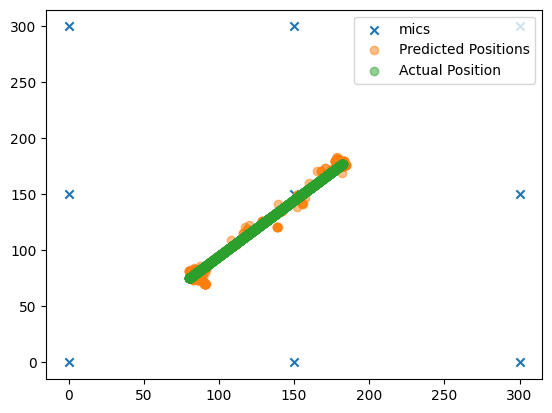

In [405]:
mic_locs_arr = np.array(mic_locs)
plt.scatter(mic_locs_arr[:,0], mic_locs_arr[:,1], marker='x', label='mics')


predictions = np.array(predictions)
plt.scatter(predictions[:,0], predictions[:,1], alpha=0.5, label="Predicted Positions")
plt.scatter(pos_sub[:,0], pos_sub[:,1], alpha=0.5, label="Actual Position")
plt.legend()

In [334]:
100/sample_rate

0.00625